### Importing relevant packages

In [43]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
from pycaret.classification import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [44]:
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix




### Relevant functions

In [45]:
def season(x):
    if x.month < 3 or x.month==12:
        return 'summer'
    if x.month >=3 and x.month < 6:
        return 'autumn'
    if x.month >=6 and x.month < 9:
        return 'winter'
    if x.month >=9 and x.month < 12:
        return 'spring'

### Reading data

In [46]:
df_rain_aus = pd.read_csv('./data/rain_data_aus.csv')
df_wt = pd.read_csv('./data/wind_table_01.csv')

In [47]:
df_rain_aus['date'] = pd.to_datetime(df_rain_aus['date'], format='%Y-%M-%d')

### Unifying datasets

In [48]:
df_rain_aus = pd.read_csv('./data/rain_data_aus.csv')

winds_filenames = [f'./data/wind_table_0{i}.csv' for i in range(2,9)]

df_winds = pd.read_csv('./data/wind_table_01.csv')
for wind in winds_filenames:
    df_append = pd.read_csv(wind)
    zipy = {x: y for x, y in zip(df_append.columns,df_winds.columns)}
    df_winds = df_winds.append(df_append.rename(columns=zipy))

In [49]:
df_rain_aus['date'] = pd.to_datetime(df_rain_aus['date'], format='%Y-%m-%d')
df_winds['date'] = pd.to_datetime(df_winds['date'], format='%Y-%m-%d')

In [50]:
df_merged = pd.merge(left=df_rain_aus,
                    right = df_winds,
                    on = ['location', 'date'])

In [51]:
df_merged['amountOfRain'].dropna(inplace=True) #highly correlated with target variable
df_merged.drop(columns=['modelo_vigente'], inplace=True) #whats that?

In [52]:
df_merged.drop_duplicates(inplace=True)

### Basic ECA

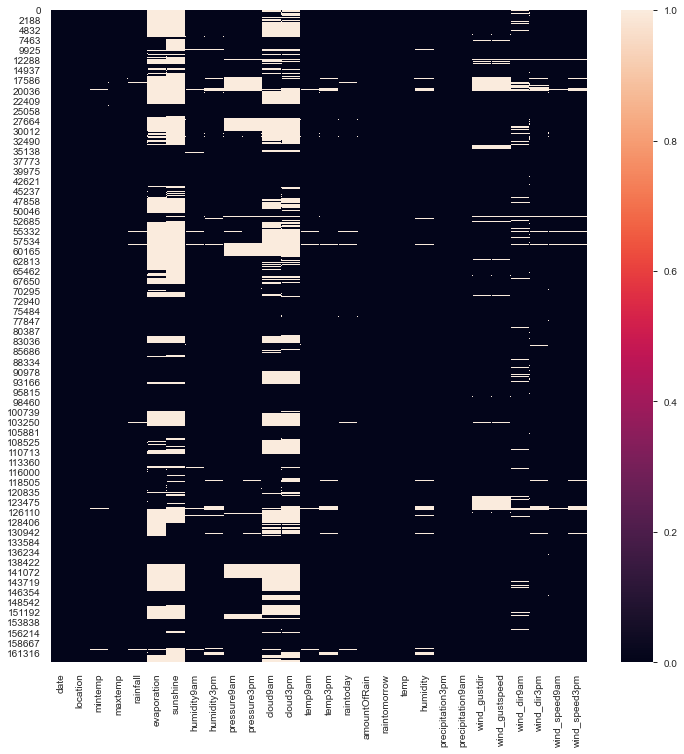

In [53]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
sns.heatmap(df_merged.isna(), ax=ax)
plt.show()

There are several features containing NaN values.
Some features seem odd, as they only contain NaN values on a fraction of the dataset and consecutively 

Specifically:
* Pressure3pm
* Pressure9am
* Windgustdir
* Windgustspeed

Code will not adress the latter two columns, as they will be eventually dropped later (due to data leakage)


In [54]:
df_merged.groupby(by='location').agg({'pressure3pm':'max', 'pressure9am':'max'}).query('pressure9am!=pressure9am')

,pressure3pm,pressure9am
location,,
MountGinini,NaN,NaN
Newcastle,NaN,NaN
Penrith,NaN,NaN
SalmonGums,NaN,NaN


In [55]:
excluded_cities = list(df_merged.groupby(by='location').agg({'pressure3pm':'max', 'pressure9am':'max'}).
                       query('pressure9am!=pressure9am').index)

For the sake of simplicity, we will not be estimating weather forecast on the above cities, as 'pressure' seemed to be a critical feature on the first sprint 


In [56]:
df_merged = df_merged[~df_merged.location.isin(excluded_cities)]

### Feature Engineering

In [57]:
#Dropping columns that would not be available at 5pm
df_merged.drop(columns=['maxtemp','mintemp', 'rainfall', 'wind_gustdir','wind_gustspeed'], inplace=True)


In [58]:
#Engineering based on functions
df_merged['season'] = df_merged['date'].apply(season)
df_merged['month'] = pd.DatetimeIndex(df_merged['date']).month
df_merged['firsthalf_year'] = df_merged['month'] <=6

#Engineering based on intraday shifts
# df_merged['amp_temp'] = df_merged['mintemp'] /  df_merged['maxtemp']
df_merged['change_wind'] = (df_merged['wind_dir9am'] != df_merged['wind_dir3pm'])

df_merged['temp_delta'] = df_merged['temp3pm'] - df_merged['temp9am']
df_merged['hum_delta'] = df_merged['humidity3pm'] - df_merged['humidity9am']
df_merged['ws_delta'] = df_merged['wind_speed3pm'] - df_merged['wind_speed9am']
df_merged['cloud_delta'] = df_merged['cloud3pm'] - df_merged['cloud9am']
df_merged['pa_delta'] = df_merged['pressure3pm'] - df_merged['pressure9am']
df_merged['prec_delta'] = df_merged['precipitation3pm'] - df_merged['precipitation9am']

#Engineering based possible relevant variables on rain forecasting
df_merged['check_sunshine'] = (df_merged['sunshine'] == 0)
df_merged['high_sunshine'] = (df_merged['sunshine'] >= df_merged['sunshine'].median())
df_merged['LowHumidity3pm'] = (df_merged['humidity3pm'] <= df_merged['humidity3pm'].median())
df_merged['LowCloud3pm'] = (df_merged['cloud3pm'] <= df_merged['cloud3pm'].median())

#Engineering on target variable
df_merged['raintomorrow'] = df_merged['raintomorrow'].replace({'No': 0, 'Yes': 1})

#Dropping unnecessary columns
df_merged.drop(columns=['date', 'amountOfRain'], inplace=True)

### Variable distplots

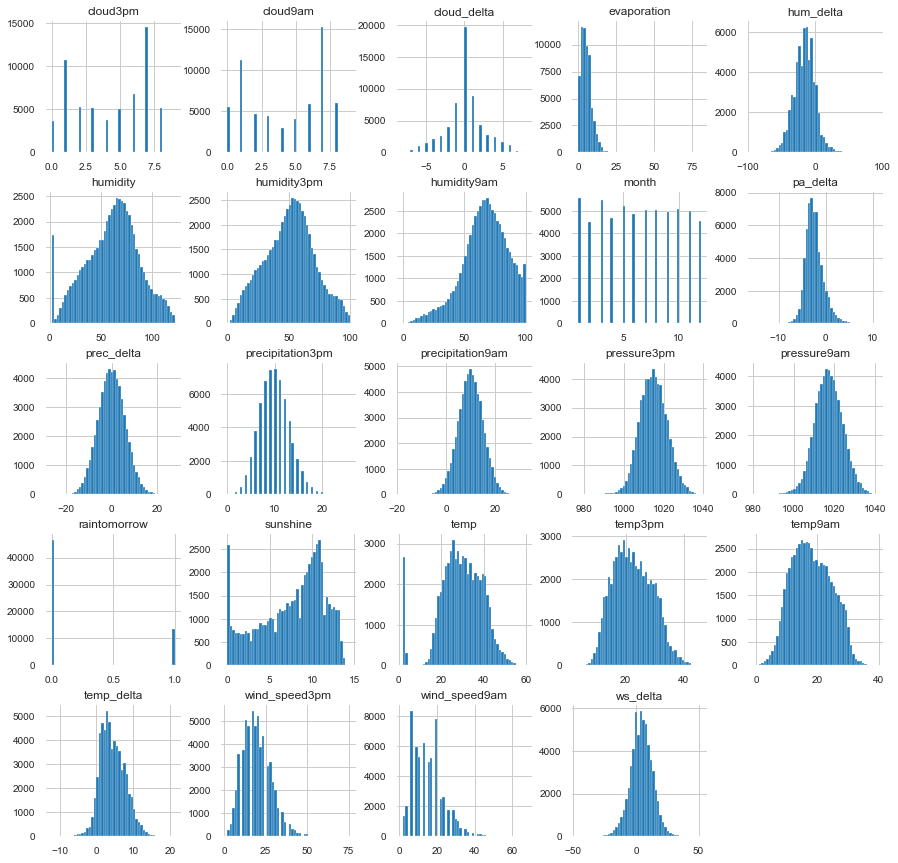

In [59]:
df_hist = df_merged.dropna().select_dtypes(exclude = ['bool','object'])
df_hist.hist(figsize = [15,15],bins = 50)
plt.show()

In [60]:
#log transformation on weird variables
# df_merged['rainfall'] = df_merged['rainfall'].apply(lambda x: np.log(x) if x>0 else x)
df_merged['evaporation'] = df_merged['evaporation'].apply(lambda x: np.log(x) if x>0 else x)
df_merged['sunshine'] = df_merged['sunshine'].apply(lambda x: np.log(x) if x>0 else x)
df_merged['temp'] = df_merged['temp'].apply(lambda x: np.log(x) if x>0 else x)

In [61]:
log_features = ['evaporation', 'sunshine', 'temp'] #'rainfall'
for i in log_features:
    df_merged[[i]] = QuantileTransformer(n_quantiles=100,
                                  output_distribution='normal',
                                  subsample=len(df_merged)).fit_transform(df_merged[[i]])

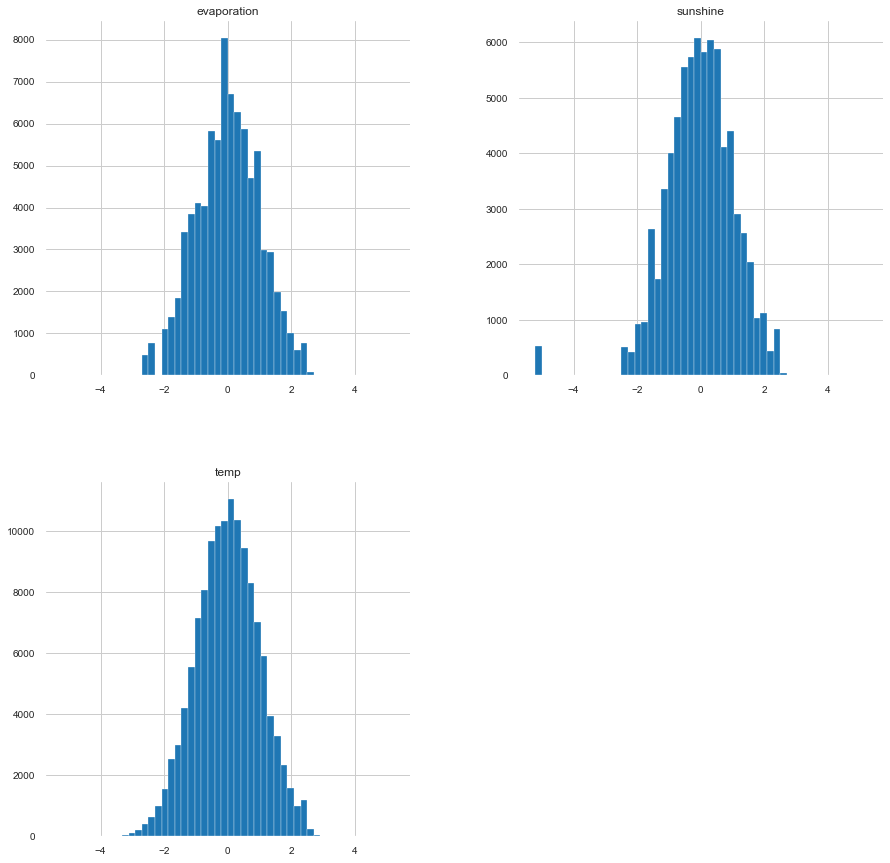

In [62]:
df_hist = df_merged[log_features]
df_hist.hist(figsize = [15,15],bins = 50)
plt.show()

In [63]:
df_merged['transformed_sunshine'] = (df_merged['sunshine'] > -4) 

### It is time for PyCarat!

In [64]:
py_carat = setup(data = df_merged, 
                 target = 'raintomorrow', 
                 silent = True,
                 verbose = False,
                 session_id=42,
                 numeric_imputation='median',
                 ignore_low_variance=True,
                 normalize=True,
                 remove_multicollinearity=True,
                 n_jobs=-1,
                 feature_selection_threshold=.3,
                 feature_selection=True,
                numeric_features = ['evaporation',
                                    'sunshine',
                                    'humidity9am',
                                    'humidity3pm',
                                    'pressure9am',
                                    'pressure3pm',
                                    'cloud9am',
                                    'cloud3pm',
                                    'temp9am',
                                    'temp3pm',
                                    'temp',
                                    'humidity',
                                    'precipitation3pm',
                                    'precipitation9am',
                                    'wind_speed9am',
                                    'wind_speed3pm',
                                    'temp_delta',
                                    'hum_delta',
                                    'ws_delta',
                                    'cloud_delta',
                                    'pa_delta',
                                    'prec_delta'],
                categorical_features = ['location',
                                        'raintoday',
                                        'wind_dir9am',
                                        'wind_dir3pm',
                                        'season',
                                        'month',
                                        'firsthalf_year',
                                        'change_wind',
                                        'check_sunshine',
                                        'high_sunshine',
                                        'LowHumidity3pm',
                                        'LowCloud3pm',
                                        'transformed_sunshine',
                                        'check_sunshine',
                                        'high_sunshine',
                                        'LowHumidity3pm',
                                        'LowCloud3pm',
                                        'transformed_sunshine']
                )

In [65]:
best_model = compare_models(fold=3, turbo=True, exclude=['knn', 'catboost', 'et', 'gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.8534,0.8826,0.5313,0.7420,0.6192,0.5315,0.5429,5.0962
1,Extreme Gradient Boosting,0.8527,0.8803,0.5396,0.7333,0.6217,0.5328,0.5425,24.3354
2,Logistic Regression,0.8446,0.8643,0.4987,0.7229,0.5902,0.4983,0.5114,1.5217
3,Linear Discriminant Analysis,0.8425,0.8615,0.5085,0.7073,0.5916,0.4973,0.5077,1.4074
4,Ridge Classifier,0.8421,0.0000,0.4427,0.7513,0.5571,0.4687,0.4930,0.2857
5,Ada Boost Classifier,0.8419,0.8624,0.4923,0.7145,0.5829,0.4895,0.5024,13.7733
6,Random Forest Classifier,0.8396,0.8411,0.4445,0.7360,0.5543,0.4637,0.4856,1.7758
7,SVM - Linear Kernel,0.8385,0.0000,0.4127,0.7596,0.5323,0.4454,0.4768,1.0541
8,Decision Tree Classifier,0.7797,0.6891,0.5248,0.5087,0.5166,0.3740,0.3741,4.6157
9,Naive Bayes,0.6993,0.7831,0.7587,0.4085,0.5310,0.3378,0.3730,0.1963


In [66]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8520,0.8810,0.5303,0.7363,0.6165,0.5278,0.5387
1,0.8524,0.8815,0.5176,0.7470,0.6115,0.5241,0.5375
2,0.8552,0.8851,0.5371,0.7463,0.6246,0.5379,0.5490
3,0.8567,0.8873,0.5444,0.7483,0.6303,0.5442,0.5548
4,0.8551,0.8857,0.5420,0.7425,0.6266,0.5394,0.5497
5,0.8568,0.8880,0.5303,0.7589,0.6243,0.5393,0.5525
6,0.8491,0.8806,0.5305,0.7232,0.6120,0.5211,0.5307
7,0.8566,0.8851,0.5408,0.7507,0.6287,0.5427,0.5539
8,0.8506,0.8816,0.5264,0.7323,0.6125,0.5230,0.5339
9,0.8548,0.8790,0.5293,0.7502,0.6207,0.5342,0.5466


In [67]:
tuned_lgbm = tune_model(lgbm, n_iter=30,optimize='Recall') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8368,0.8602,0.5566,0.6620,0.6048,0.5029,0.5059
1,0.8401,0.8560,0.5449,0.6788,0.6046,0.5058,0.5106
2,0.8331,0.8583,0.5581,0.6487,0.6000,0.4953,0.4975
3,0.8436,0.8653,0.5610,0.6847,0.6167,0.5197,0.5238
4,0.8335,0.8607,0.5522,0.6522,0.5981,0.4940,0.4967
5,0.8370,0.8631,0.5454,0.6673,0.6002,0.4991,0.5031
6,0.8349,0.8564,0.5554,0.6563,0.6016,0.4984,0.5012
7,0.8366,0.8614,0.5603,0.6601,0.6061,0.5039,0.5066
8,0.8337,0.8558,0.5547,0.6521,0.5995,0.4954,0.4980
9,0.8334,0.8509,0.5430,0.6553,0.5939,0.4902,0.4936


In [68]:
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

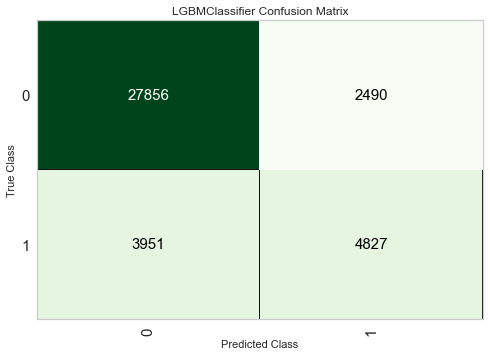

In [69]:
plot_model(tuned_lgbm, plot='confusion_matrix')

In [70]:
tuned_lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.7, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0,
               n_estimators=170, n_jobs=-1, num_leaves=60, objective=None,
               random_state=42, reg_alpha=0.1, reg_lambda=0.8, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [71]:
optimize_threshold(tuned_lgbm, 
                   true_negative = 2, 
                   false_negative = -3,
                   true_positive = 3,
                   false_positive = 0
                  )

Optimized Probability Threshold: 0.17 | Optimized Cost Function: 61590


In [72]:
predict_model(tuned_lgbm,probability_threshold = .17)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7868,0.8577,0.7507,0.5171,0.6124,0.4721,0.4877


,precipitation3pm,cloud_delta,precipitation9am,wind_dir9am_NNW,firsthalf_year_True,ws_delta,location_Portland,location_Walpole,wind_dir9am_E,location_Wollongong,...,location_Mildura,temp,wind_dir3pm_NW,wind_speed9am,location_MountGambier,cloud9am,location_AliceSprings,raintomorrow,Label,Score
0,-1.266060,-0.018340,0.225229,0.0,0.0,-1.485201,0.0,0.0,1.0,0.0,...,0.0,1.562112,0.0,0.540194,0.0,-1.971954,1.0,0,0,0.0000
1,-1.266060,-3.626690,0.624050,0.0,1.0,0.143012,0.0,0.0,0.0,0.0,...,0.0,-1.913096,0.0,-0.141558,0.0,1.430529,0.0,0,0,0.0190
2,0.625741,-0.018340,-2.085794,1.0,0.0,-0.322192,0.0,0.0,0.0,0.0,...,0.0,0.048734,0.0,-0.596059,0.0,0.154598,0.0,0,0,0.1032
3,-0.635460,-0.018340,0.062497,0.0,0.0,-1.834104,0.0,0.0,0.0,0.0,...,0.0,1.665460,0.0,1.108320,0.0,-1.546643,0.0,0,0,0.0001
4,1.571641,-0.018340,-1.174275,0.0,0.0,-0.554794,0.0,0.0,0.0,0.0,...,0.0,-1.755751,0.0,0.881070,0.0,-1.121333,0.0,0,0,0.0043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39119,-1.266060,-0.018340,-0.775639,0.0,1.0,-1.834104,0.0,0.0,0.0,0.0,...,0.0,2.361032,0.0,0.653819,0.0,0.154598,0.0,0,0,0.0102
39120,2.832841,-0.018340,0.928065,0.0,0.0,1.189720,0.0,0.0,1.0,0.0,...,0.0,0.078521,0.0,-0.823309,0.0,-0.270713,0.0,0,0,0.0186
39121,0.941041,2.043573,0.367641,0.0,0.0,-0.787395,0.0,0.0,0.0,0.0,...,0.0,-0.536694,0.0,-0.596059,0.0,-1.546643,0.0,0,0,0.0367
39122,-1.266060,-0.018340,-1.991395,0.0,1.0,0.143012,0.0,0.0,0.0,0.0,...,0.0,-0.295458,0.0,-1.618686,0.0,0.154598,0.0,1,1,0.3066
